# 1. Necessary functions and libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly

## Importing helper function for Random Forest Feature Importance

In [289]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## Importing OLS API for modeling

In [290]:
import statsmodels.api as ols

## Importing XGBoost API and Logistic Regression for comparing accuracy

In [296]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

## Utility Functions

In [135]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from itertools import chain,cycle
import plotly.graph_objects as go
pd.set_option('display.max_rows', None)
np.set_printoptions(precision = 3)
def drawline():
    print('-'*117)
def verticleCanvas(size):
    f, ax = plt.subplots(1, 2, figsize=size)
    return [f, ax]

def plotRadar(coef_male, coef_female, range_value, title):
    categories = coef_male.index.to_numpy()
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
          r=coef_male.to_numpy(),
          theta=categories,
          fill='toself',
          name='Before'
    ))
    fig.add_trace(go.Scatterpolar(
          r=coef_female.to_numpy(),
          theta=categories,
          fill='toself',
          name='After'
    ))

    fig.update_layout(
      title=title,
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=range_value
        )),
      showlegend=True
    )

    fig.show()
def normalizeAtt(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
def normalize(df):
    result = df.copy()
    result.iloc[:,0:-1] = scaler.fit_transform(result.iloc[:,0:-1].to_numpy())
    return result

In [82]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>td{white-space: nowrap !important;}</style>"))
pd.set_option('display.expand_frame_repr', False)
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [5]:
def featureImportancePlot(categorical, numerical, rf, title):
    feature_names = np.r_[categorical, numerical]
    fig, ax = verticleCanvas((24, 12))
    gender = ["Male", "Female"]  
    color = ["blue", "red"]
    for i in range(2):
        tree_feature_importances = rf[i].named_steps["classifier"].feature_importances_
        sorted_idx = tree_feature_importances.argsort()
        y_ticks = np.arange(0, len(feature_names))
        ax[i].barh(y_ticks, tree_feature_importances[sorted_idx], color=color[i])
        ax[i].set_yticks(y_ticks)
        ax[i].set_yticklabels(feature_names[sorted_idx])
        ax[i].set_title(title.format(gender[i]))
        fig.tight_layout()
    plt.show()
# Plot the tree with max depth 2
def pltTree(X_train,y_train, estimator):
    # Fit the tree with max depth 2
    estimator.fit(X_train, y_train)
    from sklearn.tree import plot_tree

    f = plt.figure(figsize=(12,12))
    plot_tree(estimator, filled=True, rounded=True, 
              feature_names=X_train.columns, 
              class_names=["N","Y"])

In [6]:
# preparing the data for train and test
def split(train, response):
    X=train.drop([response], axis = 1)
    y=train[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return [X_train, X_test, y_train, y_test]

In [281]:
categories = {
    "similarities": [], 
    "attrBefore":['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'match'], 
    "attrAfter":['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'match'], 
    "satIncome": ['log_mn_sat','log_income','match']
}


# 2. Random Forest Model 

### Prepare random forest

In [7]:
def randomForestMDI(categorical_columns, numerical_columns, max_depth=20):
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])
    preprocessing = ColumnTransformer(
        [
            ("cat", categorical_encoder, categorical_columns),
            ("num", numerical_pipe, numerical_columns),
        ]
    )
    rf = Pipeline(
        [
            ("preprocess", preprocessing),
            ("classifier", RandomForestClassifier(random_state=42, max_depth=max_depth)),
        ]
    )
    return rf

## 2.1 Before the date variables: attribute scores that male and female want 

In [197]:
before_male = pd.read_csv("data/attrBefore_male.csv")
before_female = pd.read_csv("data/attrBefore_female.csv")
before_male = before_male.drop(["gender", "Unnamed: 0"], axis = 1).dropna()
before_female = before_female.drop(["gender", "Unnamed: 0"], axis = 1).dropna()
before_male = normalize(before_male)
before_female = normalize(before_female)

In [137]:
print("----------------------Sneak peak into male data----------------------")
print(before_male.head(5))
print("----------------------Sneak peak into female data----------------------")
print(before_female.head(5))

----------------------Sneak peak into male data----------------------
    attr1_1   sinc1_1  intel1_1   fun1_1    amb1_1   shar1_1  match
0  0.639151  0.472015  0.036682  0.36458 -1.472285 -0.908524      0
1  0.639151  0.472015  0.036682  0.36458 -1.472285 -0.908524      0
2  0.639151  0.472015  0.036682  0.36458 -1.472285 -0.908524      0
3  0.639151  0.472015  0.036682  0.36458 -1.472285 -0.908524      0
4  0.639151  0.472015  0.036682  0.36458 -1.472285 -0.908524      0
----------------------Sneak peak into female data----------------------
    attr1_1   sinc1_1  intel1_1    fun1_1    amb1_1   shar1_1  match
0 -0.317312  0.258586 -0.135311 -0.431555  0.379801  0.440235      0
1 -0.317312  0.258586 -0.135311 -0.431555  0.379801  0.440235      0
2 -0.317312  0.258586 -0.135311 -0.431555  0.379801  0.440235      1
3 -0.317312  0.258586 -0.135311 -0.431555  0.379801  0.440235      1
4 -0.317312  0.258586 -0.135311 -0.431555  0.379801  0.440235      1


In [138]:
before_male = before_male.rename(columns={"attr1_1" : "Attractive", "sinc1_1":"Sincere", 
                            "intel1_1":"Intelligent", "fun1_1":"Humorous",
                           "amb1_1":"Ambition", "shar1_1": "SharedInterest"})
before_female = before_female.rename(columns={"attr1_1" : "Attractive", "sinc1_1":"Sincere", 
                            "intel1_1":"Intelligent", "fun1_1":"Humorous",
                           "amb1_1":"Ambition", "shar1_1": "SharedInterest"})

In [139]:
numerical_columns  = np.array(['Attractive', 'Sincere', 'Intelligent', 'Humorous', 'Ambition','SharedInterest'])
categorical_columns = []

In [140]:
# Train and test split on male 
X_train_m, X_test_m, y_train_m, y_test_m = split(before_male, "match")
# Train and test split on female
X_train_f, X_test_f, y_train_f, y_test_f = split(before_female, "match")
rf_before = [randomForestMDI(categorical_columns, numerical_columns), randomForestMDI(categorical_columns, numerical_columns)]

In [141]:
rf_before[0].fit(X_train_m, y_train_m)
print("RF train accuracy: %0.3f" % rf_before[0].score(X_train_m, y_train_m))
print("RF test accuracy: %0.3f" % rf_before[0].score(X_test_m, y_test_m))

RF train accuracy: 0.843
RF test accuracy: 0.800


In [142]:
rf_before[1].fit(X_train_f, y_train_f)
print("RF train accuracy: %0.3f" % rf_before[1].score(X_train_f, y_train_f))
print("RF test accuracy: %0.3f" % rf_before[1].score(X_test_f, y_test_f))

RF train accuracy: 0.837
RF test accuracy: 0.835


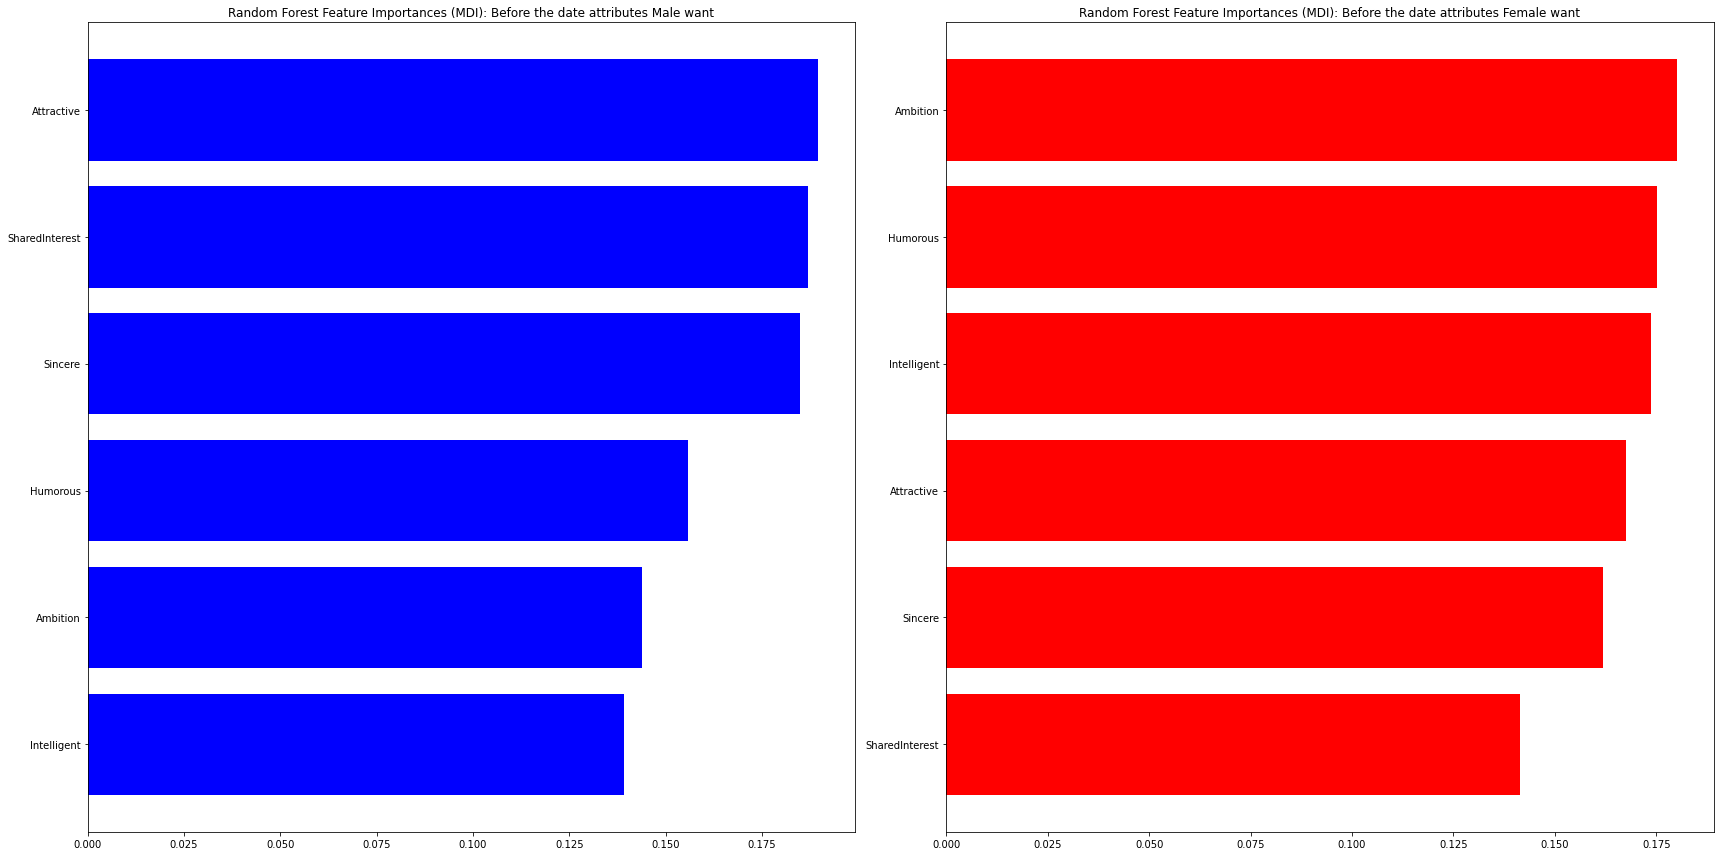

In [143]:
featureImportancePlot(categorical_columns, numerical_columns, rf_before, "Random Forest Feature Importances (MDI): Before the date attributes {} want")

## 2.2 After the date variables: attribute scores that male and female rated on partner 

In [198]:
after_male = pd.read_csv("data/attrAfter_male.csv")
after_female = pd.read_csv("data/attrAfter_female.csv")
after_male = after_male.drop(["gender", "Unnamed: 0"], axis = 1).dropna()
after_female = after_female.drop(["gender", "Unnamed: 0"], axis = 1).dropna()
after_male = normalize(after_male)
after_female = normalize(after_female)

In [145]:
print("----------------------Sneak peak into male data----------------------")
print(after_male.head(5))
print("----------------------Sneak peak into female data----------------------")
print(after_female.head(5))

----------------------Sneak peak into male data----------------------
       attr      sinc     intel       fun       amb      shar  match
0 -0.241041  0.474153  0.486403  0.810546  0.819620  0.224778      0
1  0.839902 -0.148167 -0.849464  1.355622  0.236666 -0.732924      0
2  0.299431  0.474153 -0.849464 -0.824684  0.819620 -0.732924      0
3 -0.241041 -0.148167  0.486403  0.265469  0.236666 -0.254073      0
4 -0.241041  0.474153  0.486403  0.810546  0.236666  0.224778      0
----------------------Sneak peak into female data----------------------
       attr      sinc     intel       fun       amb      shar  match
0  0.017626  1.023735 -0.301747  0.338632 -0.532651 -0.194969      0
1  0.521132  0.478955 -0.301747  0.828492 -1.082019  0.264140      0
2 -0.485879  0.478955  0.970646  0.828492 -1.082019  0.723250      1
3  0.521132 -0.610603  0.334450  0.338632 -0.532651  1.182359      1
4 -0.485879 -0.610603 -0.301747  0.338632 -0.532651  0.264140      1


In [146]:
after_male = after_male.rename(columns={"attr" : "Attractive", "sinc":"Sincere", 
                            "intel":"Intelligent", "fun":"Humorous",
                           "amb":"Ambition", "shar": "SharedInterest"})
after_female = after_female.rename(columns={"attr" : "Attractive", "sinc":"Sincere", 
                            "intel":"Intelligent", "fun":"Humorous",
                           "amb":"Ambition", "shar": "SharedInterest"})

In [147]:
numerical_columns  = np.array(['Attractive', 'Sincere', 'Intelligent', 'Humorous', 'Ambition','SharedInterest'])
categorical_columns = []

In [148]:
# Train and test split on male 
X_train_m, X_test_m, y_train_m, y_test_m = split(after_male, "match")
# Train and test split on female
X_train_f, X_test_f, y_train_f, y_test_f = split(after_female, "match")
rf_after = [randomForestMDI(categorical_columns, numerical_columns), randomForestMDI(categorical_columns, numerical_columns)]

In [149]:
rf_after[0].fit(X_train_m, y_train_m)
print("RF train accuracy: %0.3f" % rf_before[0].score(X_train_m, y_train_m))
print("RF test accuracy: %0.3f" % rf_before[0].score(X_test_m, y_test_m))

RF train accuracy: 0.824
RF test accuracy: 0.837


In [150]:
rf_after[1].fit(X_train_f, y_train_f)
print("RF train accuracy: %0.3f" % rf_after[1].score(X_train_f, y_train_f))
print("RF test accuracy: %0.3f" % rf_after[1].score(X_test_f, y_test_f))

RF train accuracy: 0.958
RF test accuracy: 0.799


## Result

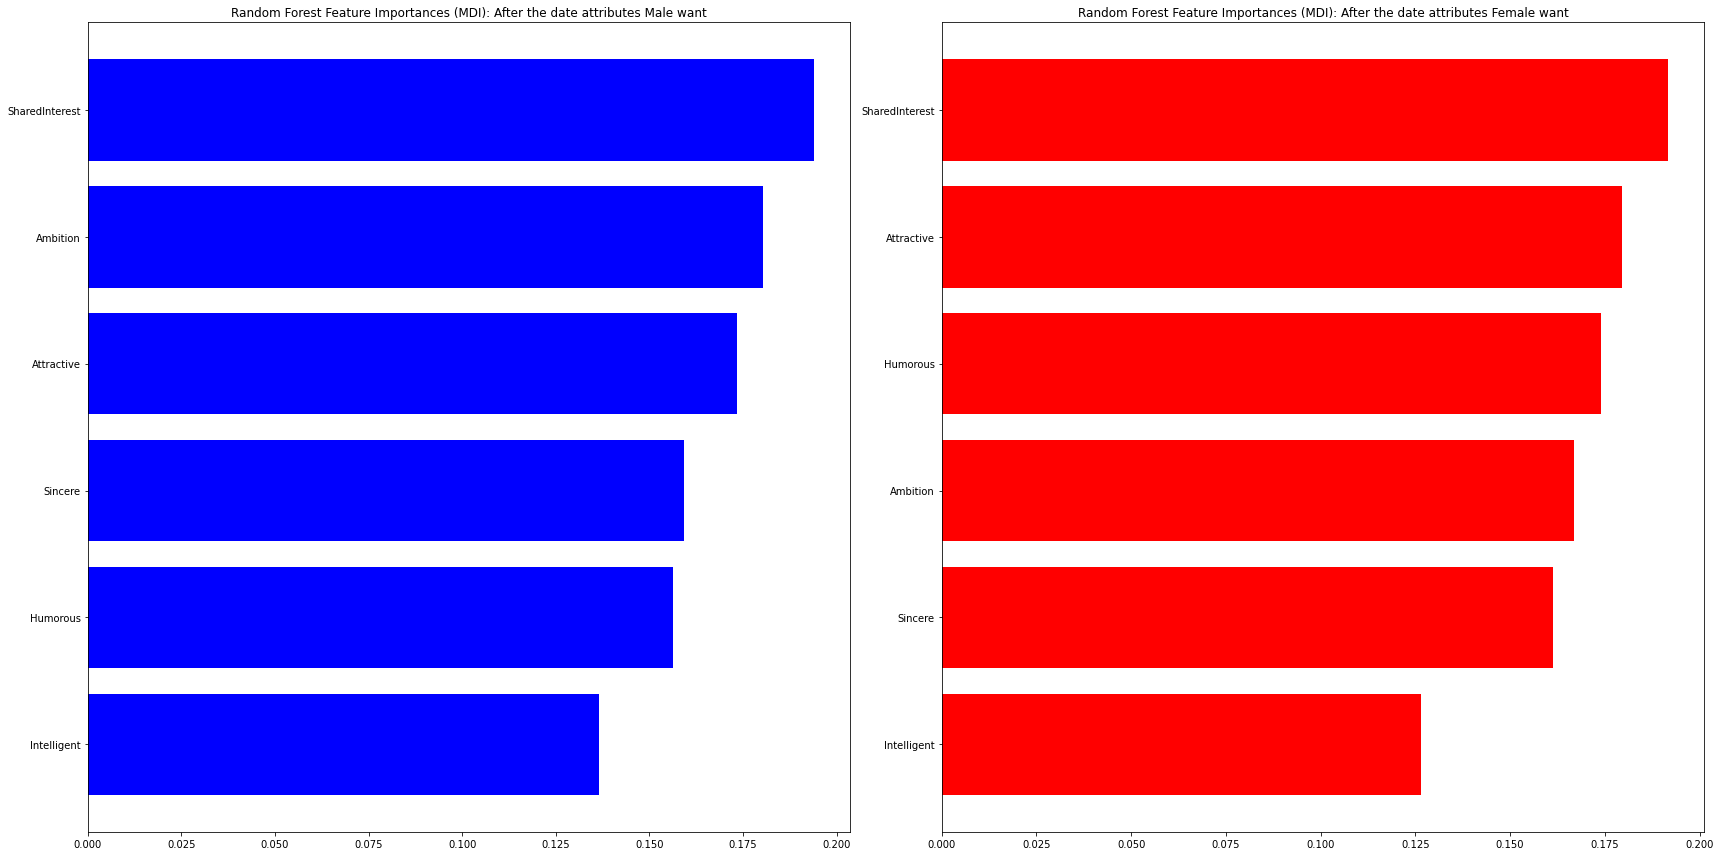

In [151]:
featureImportancePlot(categorical_columns, numerical_columns, rf_after,"Random Forest Feature Importances (MDI): After the date attributes {} want")

# Comparing before and after the date

In [152]:
Feature_Coef_Before_Male = pd.Series(rf_before[0].named_steps["classifier"].feature_importances_, index = numerical_columns)
Feature_Coef_Before_Female = pd.Series(rf_before[1].named_steps["classifier"].feature_importances_, index = numerical_columns)
Feature_Coef_After_Male = pd.Series(rf_after[0].named_steps["classifier"].feature_importances_, index = numerical_columns)
Feature_Coef_After_Female = pd.Series(rf_after[1].named_steps["classifier"].feature_importances_, index = numerical_columns)

In [153]:
plotRadar(Feature_Coef_Before_Male, Feature_Coef_After_Male,[0,0.2], "Importance of attribute variables: before and after. Partner's  that male want ")

In [154]:
plotRadar(Feature_Coef_Before_Female, Feature_Coef_After_Female,[0,0.2], "Importance of attribute variables: before and after. Partner's  that female want ")

## 2.3 In the space of presence income and intelligence, which one would determine you get a date

In [162]:
satIncome_male = pd.read_csv("data/satIncome_male.csv")
satIncome_female = pd.read_csv("data/satIncome_female.csv")
satIncome_male = satIncome_male.drop(["gender", "Unnamed: 0", "mn_sat", "income"], axis = 1).dropna()
satIncome_female = satIncome_female.drop(["gender", "Unnamed: 0", "mn_sat", "income"], axis = 1).dropna()

['log_mn_sat', 'log_income', 'match']

In [163]:
# Rearrange the columns of datasets
cols = satIncome_male.columns.tolist()
cols = cols[1:]+cols[:1]
satIncome_male = satIncome_male[cols]
satIncome_female = satIncome_female[cols]

In [164]:
print("------Sneak peak into male data-------")
print(satIncome_male.head(5))
print("------Sneak peak into female data-------")
print(satIncome_female.head(5))

------Sneak peak into male data-------
   log_mn_sat  log_income  match
0    7.038784    10.63287      0
1    7.038784    10.63287      0
2    7.038784    10.63287      0
3    7.038784    10.63287      0
4    7.038784    10.63287      0
------Sneak peak into female data-------
   log_mn_sat  log_income  match
0    6.975414   10.699778      0
1    6.975414   10.699778      0
2    6.975414   10.699778      0
3    6.975414   10.699778      0
4    6.975414   10.699778      0


In [165]:
satIncome_female = normalize(satIncome_female)
satIncome_male = normalize(satIncome_male)

In [166]:
numerical_columns  = np.array(['log_mn_sat', 'log_income'])
categorical_columns = []

In [167]:
# Train and test split on male 
X_train_m, X_test_m, y_train_m, y_test_m = split(satIncome_male, "match")
# Train and test split on female
X_train_f, X_test_f, y_train_f, y_test_f = split(satIncome_female, "match")

rf_satIncome = [randomForestMDI(categorical_columns, numerical_columns), randomForestMDI(categorical_columns, numerical_columns)]

In [168]:
rf_satIncome[0].fit(X_train_m, y_train_m)
print("RF train accuracy: %0.3f" % rf_satIncome[0].score(X_train_m, y_train_m))
print("RF test accuracy: %0.3f" % rf_satIncome[0].score(X_test_m, y_test_m))

RF train accuracy: 0.854
RF test accuracy: 0.828


In [169]:
rf_satIncome[1].fit(X_train_f, y_train_f)
print("RF train accuracy: %0.3f" % rf_satIncome[1].score(X_train_f, y_train_f))
print("RF test accuracy: %0.3f" % rf_satIncome[1].score(X_test_f, y_test_f))

RF train accuracy: 0.856
RF test accuracy: 0.820


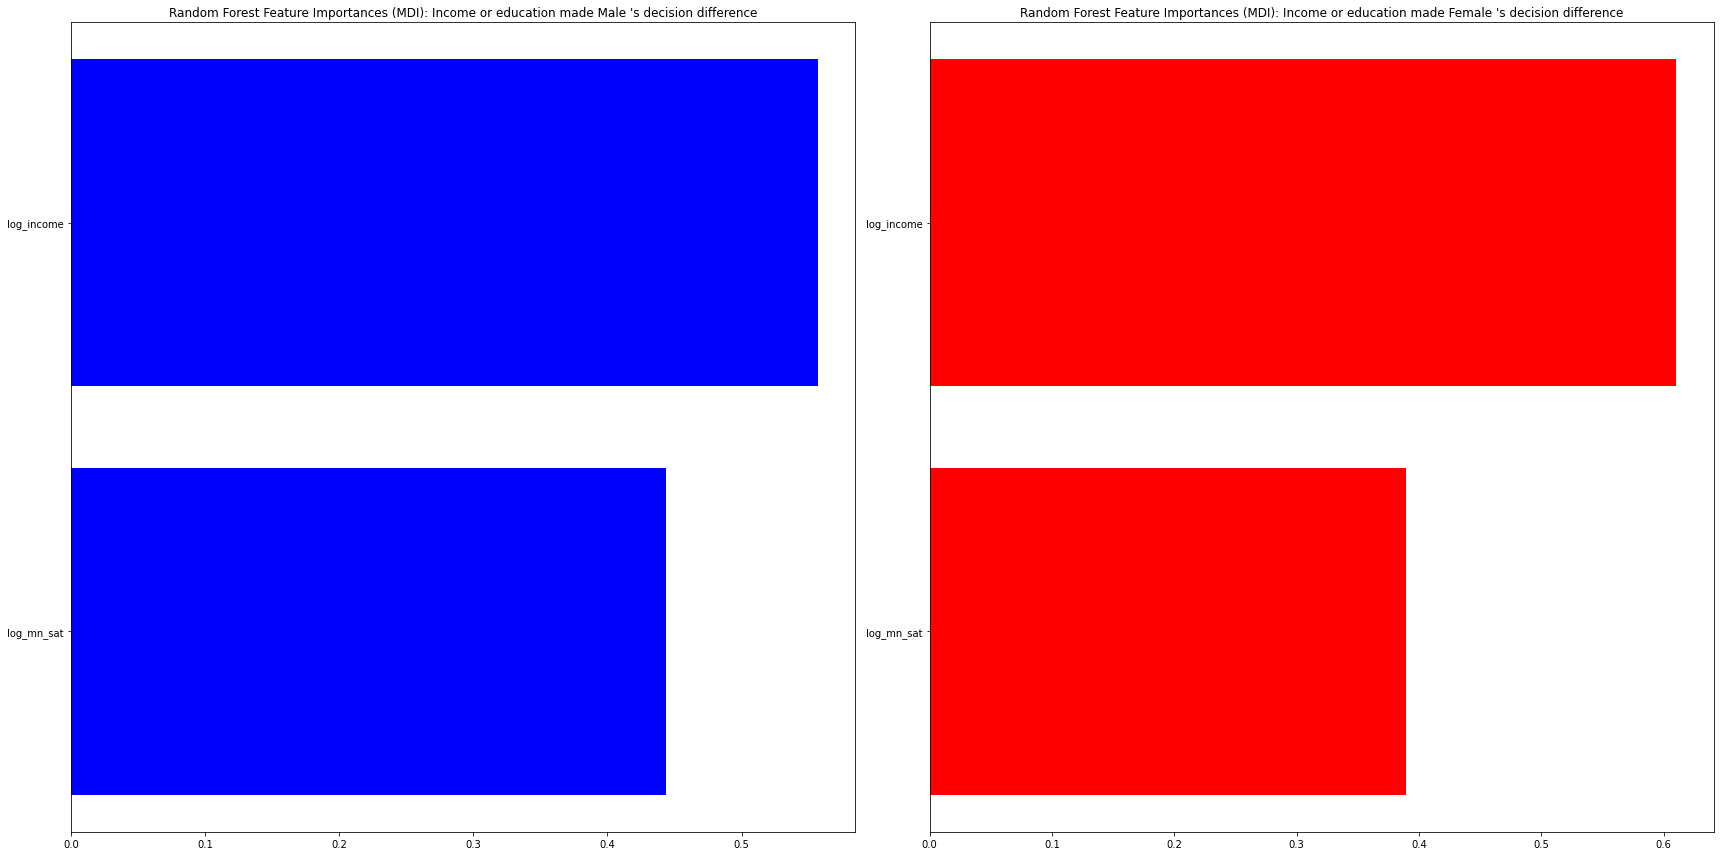

In [170]:
featureImportancePlot(categorical_columns, numerical_columns, rf_satIncome, "Random Forest Feature Importances (MDI): Income or education made {} 's decision difference")

## 2.4 Which similarity will increase you chance of getting a date

In [234]:
similar_male = pd.read_csv("data/similar_male.csv")
similar_female = pd.read_csv("data/similar_female.csv")

In [235]:
# Check again if dataset is clean or not ? The shape are right not ? If they are right, 
# female and male dataframes should have 8299 rows in total and 5 columns
print("Missing Values after mereged and the shape of desired similar dataset")
print(pd.concat([similar_male, similar_female], axis = 0).isnull().sum())

Missing Values after mereged and the shape of desired similar dataset
SameField         0
SameRegion        0
SameRace          0
SharedInterest    0
match             0
dtype: int64


In [236]:
print("---------------Sneak peak into male data--------------")
print(similar_male.head(5))
print("---------------Sneak peak into female data---------------")
print(similar_female.head(5))

---------------Sneak peak into male data--------------
   SameField  SameRegion  SameRace  SharedInterest  match
0          0           0         0        0.635034      0
1          0           0         1        0.713003      0
2          0           0         1        0.371470      0
3          0           0         1        0.370042      0
4          0           0         1        0.467749      0
---------------Sneak peak into female data---------------
   SameField  SameRegion  SameRace  SharedInterest  match
0          0           0         0        0.635034      0
1          1           0         0        0.777257      0
2          1           1         1        0.656621      1
3          1           1         0        0.830314      1
4          1           1         0        0.669602      1


In [237]:
# Since the random forest are biased toward the large-cardinality vairable - variable with more values(continuos)
# So in order to be unbiased in this model, We will aggregate variable SharedInterest into 2 
# values only - categorical variable
similar_female.loc[similar_female.iloc[:,-2] > 0.5] = 1
similar_female.loc[similar_female.iloc[:,-2] <= 0.5] = 0
similar_male.loc[similar_male.iloc[:,-2] > 0.5] = 1
similar_male.loc[similar_male.iloc[:,-2] <= 0.5] = 0

In [238]:
print("---------------Sneak peak into male data--------------")
print(similar_male.head(5))
print("---------------Sneak peak into female data---------------")
print(similar_female.head(5))

---------------Sneak peak into male data--------------
   SameField  SameRegion  SameRace  SharedInterest  match
0          1           1         1             1.0      1
1          1           1         1             1.0      1
2          0           0         0             0.0      0
3          0           0         0             0.0      0
4          0           0         0             0.0      0
---------------Sneak peak into female data---------------
   SameField  SameRegion  SameRace  SharedInterest  match
0          1           1         1             1.0      1
1          1           1         1             1.0      1
2          1           1         1             1.0      1
3          1           1         1             1.0      1
4          1           1         1             1.0      1


In [239]:
numerical_columns  = []
categorical_columns = ["SameField","SameRegion","SameRace","SharedInterest"]

In [240]:
# Train and test split on male 
X_train_m, X_test_m, y_train_m, y_test_m = split(similar_male, "match")
# Train and test split on female
X_train_f, X_test_f, y_train_f, y_test_f = split(similar_female, "match")

rf_similar = [randomForestMDI(categorical_columns, numerical_columns, 6), randomForestMDI(categorical_columns, numerical_columns, 6)]

In [241]:
rf_similar[0].fit(X_train_m, y_train_m)
print("RF train accuracy: %0.3f" % rf_similar[0].score(X_train_m, y_train_m))
print("RF test accuracy: %0.3f" % rf_similar[0].score(X_test_m, y_test_m))

RF train accuracy: 1.000
RF test accuracy: 1.000


In [242]:
rf_similar[1].fit(X_train_f, y_train_f)
print("RF train accuracy: %0.3f" % rf_similar[1].score(X_train_f, y_train_f))
print("RF test accuracy: %0.3f" % rf_similar[1].score(X_test_f, y_test_f))

RF train accuracy: 1.000
RF test accuracy: 1.000


In [243]:
def featureImportancePlotCat(categorical, numerical, rf, title):
    fig, ax = verticleCanvas((24, 12))
    gender = ["Male", "Female"]  
    color = ["blue", "red"]
    for i in range(2):
        ohe = rf[i].named_steps["preprocess"].named_transformers_["cat"]
        feature_names = ohe.get_feature_names_out(categorical_columns)
        feature_names = np.r_[feature_names, numerical_columns]

        tree_feature_importances = rf[i].named_steps["classifier"].feature_importances_
        sorted_idx = tree_feature_importances.argsort()
        y_ticks = np.arange(0, len(feature_names))
        ax[i].barh(y_ticks, tree_feature_importances[sorted_idx], color=color[i])
        ax[i].set_yticks(y_ticks)
        ax[i].set_yticklabels(feature_names[sorted_idx])
        ax[i].set_title(title.format(gender[i]))
        fig.tight_layout()
    plt.show()

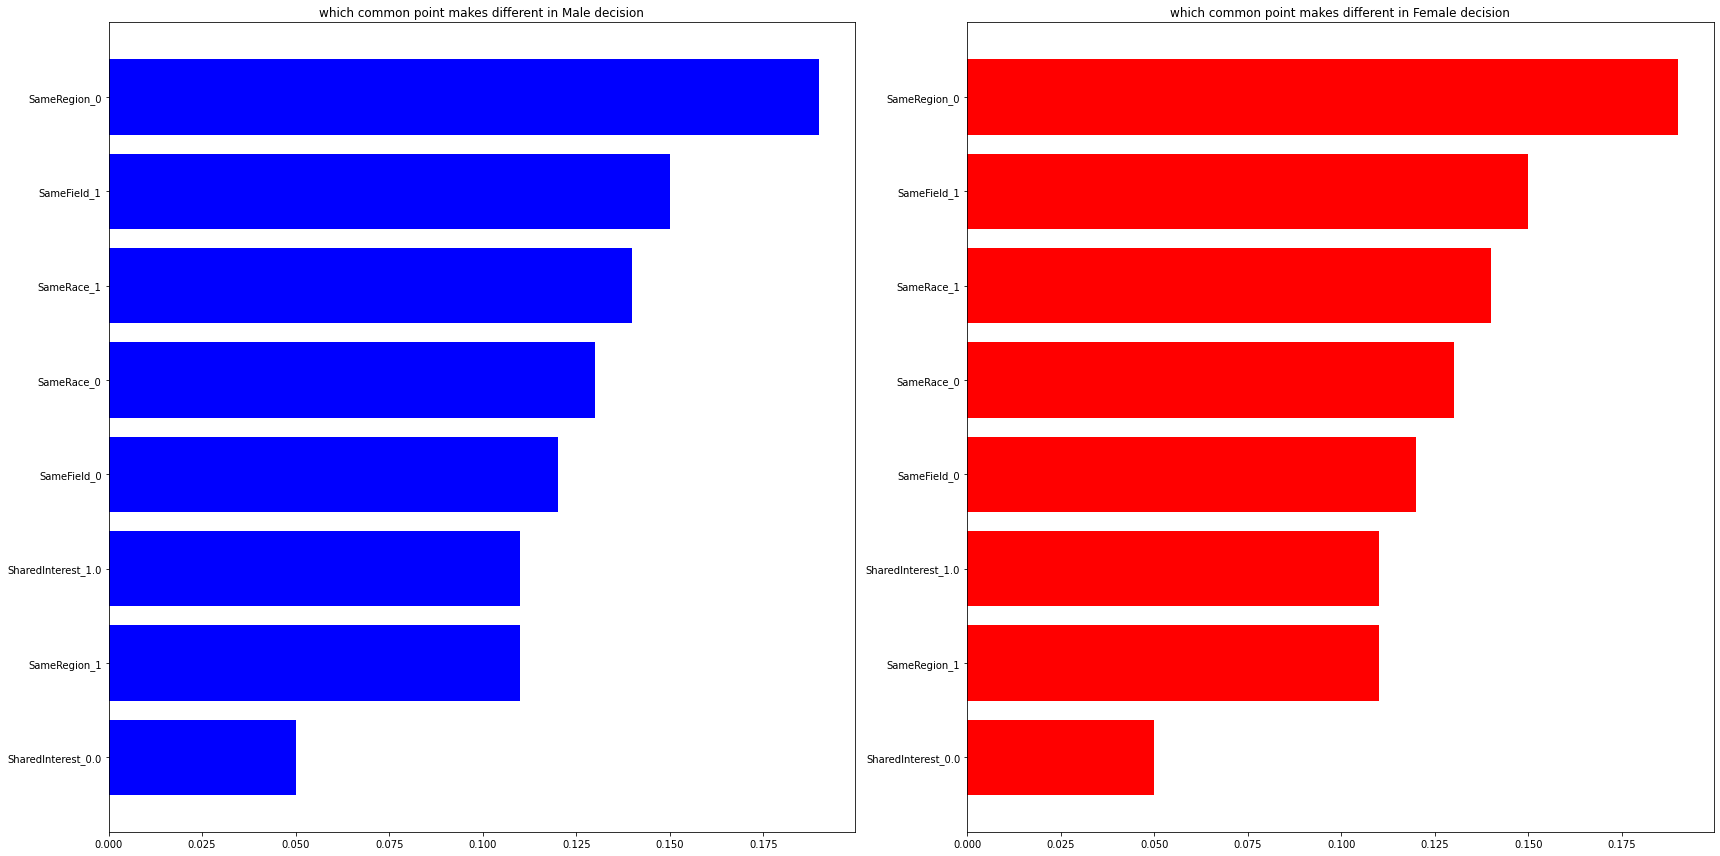

In [244]:
featureImportancePlotCat(categorical_columns, numerical_columns, rf_similar, "which common point makes different in {} decision")


# 3. OLS Modelling

## 3.1 Before the date variables: attribute scores that male and female want 

In [247]:
import statsmodels.api as ols
#OLS MODEL
attr = ols.OLS(before_male["match"], before_male.iloc[:,0:6])
result = attr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              3.599
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                     0.00147
Time:                        11:38:19   Log-Likelihood:                         -1911.7
No. Observations:                3547   AIC:                                      3835.
Df Residuals:                    3541   BIC:                                      3872.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
attr1_1       -0.0478      0.034     -1.415      0.157      -0.114       0.018
sinc1_1       -0.0509      0.020     -2.607      0.009      -0.089      -0.013
intel1_1      -0.0186      0.018     -1.012      0.311      -0.055       0.017
fun1_1        -0.0194      0.018     -1.073      0.283      -0.055       0.016
amb1_1        -0.0166      0.015     -1.130      0.258      -0.045       0.012
shar1_1       -0.0391      0.018     -2.179      0.029      -0.074      -0.004
==============================================================================
Omnibus:                      942.798   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1869.317
Skew:                           1.710   Prob(JB):                         0.00
Kurtosis:                       3.975   Cond. No.                         10.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [248]:
before_male.describe()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,match
count,3.547000e+03,3.547000e+03,3.547000e+03,3.547000e+03,3.547000e+03,3.547000e+03,3547.000000
mean,-4.807732e-17,-8.012887e-17,-8.012887e-18,1.201933e-16,-8.012887e-17,-1.121804e-16,0.173104
std,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,1.000141e+00,0.378391
min,-1.495737e+00,-2.255017e+00,-2.947313e+00,-2.620438e+00,-1.472285e+00,-1.657466e+00,0.000000
25%,-5.236204e-01,-8.192348e-01,-4.109173e-01,-3.816741e-01,-6.246184e-01,-9.085240e-01,0.000000
50%,-2.651430e-01,1.161372e-01,3.668202e-02,6.607855e-02,2.230478e-01,-1.595819e-01,0.000000
75%,2.623619e-01,4.720149e-01,5.230732e-01,3.645803e-01,6.468810e-01,6.028412e-01,0.000000
max,5.537411e+00,3.199047e+00,3.447389e+00,4.842107e+00,7.512978e+00,2.836186e+00,1.000000


In [249]:
before_male_coef = result.params.abs()
print(before_male_coef)

attr1_1     0.047762
sinc1_1     0.050869
intel1_1    0.018625
fun1_1      0.019432
amb1_1      0.016573
shar1_1     0.039102
dtype: float64


In [250]:
import statsmodels.api as ols
#OLS MODEL
attr = ols.OLS(before_female["match"], before_female.iloc[:,0:6])
result = attr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              3.089
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                     0.00511
Time:                        11:38:25   Log-Likelihood:                         -1811.1
No. Observations:                3385   AIC:                                      3634.
Df Residuals:                    3379   BIC:                                      3671.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
attr1_1        0.1441      0.075      1.932      0.053      -0.002       0.290
sinc1_1        0.1041      0.053      1.980      0.048       0.001       0.207
intel1_1       0.1077      0.054      1.993      0.046       0.002       0.214
fun1_1         0.1033      0.044      2.340      0.019       0.017       0.190
amb1_1         0.0926      0.044      2.117      0.034       0.007       0.178
shar1_1        0.0732      0.046      1.584      0.113      -0.017       0.164
==============================================================================
Omnibus:                      912.332   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1822.957
Skew:                           1.724   Prob(JB):                         0.00
Kurtosis:                       4.018   Cond. No.                         24.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [251]:
before_female_coef = result.params.abs()
print(before_female_coef)

attr1_1     0.144069
sinc1_1     0.104123
intel1_1    0.107742
fun1_1      0.103270
amb1_1      0.092626
shar1_1     0.073246
dtype: float64


## Result

In [252]:
display_side_by_side(pd.DataFrame(before_male_coef),pd.DataFrame(before_female_coef), titles=['Male','Female'])

,0
attr1_1,0.047762
sinc1_1,0.050869
intel1_1,0.018625
fun1_1,0.019432
amb1_1,0.016573
shar1_1,0.039102
,0
attr1_1,0.144069
sinc1_1,0.104123
intel1_1,0.107742


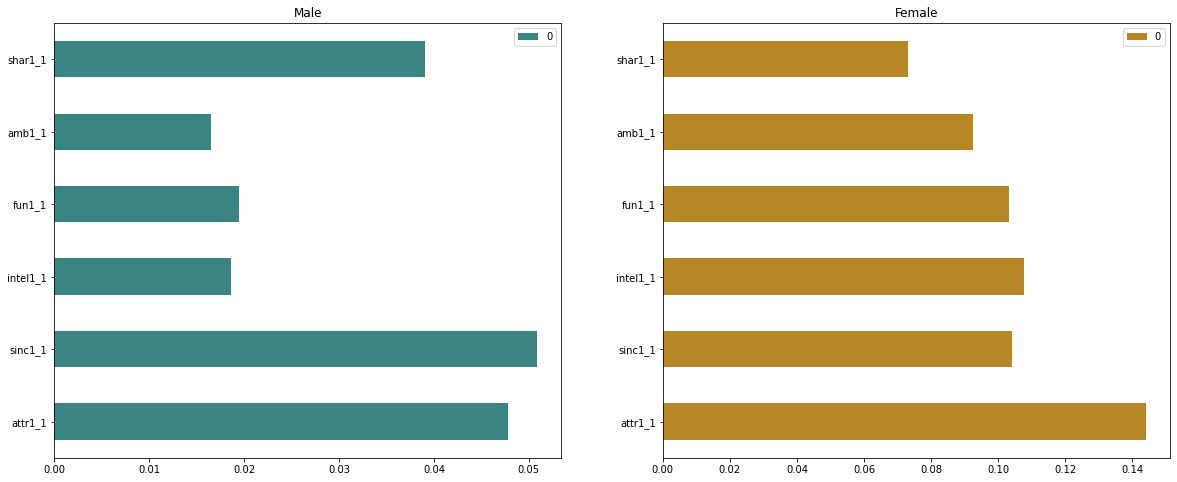

In [253]:
f, ax = verticleCanvas((20, 8))
pd.DataFrame(before_male_coef).plot(kind="barh", ax = ax[0], color = "#3B8484")
ax[0].set_title("Male")
pd.DataFrame(before_female_coef).plot(kind="barh", ax = ax[1], color = "#B78627")
ax[1].set_title("Female")
plt.show()

## 3.2 After the date variables: attribute scores that male and female rated on partner 

## After Attr Male

In [254]:
import statsmodels.api as ols
#OLS MODEL
attr = ols.OLS(after_male["match"], after_male.iloc[:,0:6])
result = attr.fit()
result.summary()                                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   0.079
Model:                            OLS   Adj. R-squared (uncentered):              0.077
Method:                 Least Squares   F-statistic:                              50.52
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                    6.91e-60
Time:                        11:38:32   Log-Likelihood:                         -1776.8
No. Observations:                3547   AIC:                                      3566.
Df Residuals:                    3541   BIC:                                      3603.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
attr           0.0576      0.008      6.876      0.000       0.041       0.074
sinc          -0.0008      0.009     -0.086      0.932      -0.019       0.017
intel          0.0114      0.010      1.114      0.265      -0.009       0.031
fun            0.0387      0.010      3.935      0.000       0.019       0.058
amb           -0.0145      0.009     -1.603      0.109      -0.032       0.003
shar           0.0469      0.009      5.421      0.000       0.030       0.064
==============================================================================
Omnibus:                      743.789   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1293.459
Skew:                           1.443   Prob(JB):                    1.35e-281
Kurtosis:                       3.651   Cond. No.                         3.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [255]:
after_male_coef = result.params.abs()
after_male_coef

attr     0.057630
sinc     0.000798
intel    0.011373
fun      0.038691
amb      0.014525
shar     0.046866
dtype: float64

In [256]:
import statsmodels.api as ols
#OLS MODEL
attr = ols.OLS(after_female["match"], after_female.iloc[:,0:6])
result = attr.fit()
result.summary()                                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              60.01
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                    6.80e-71
Time:                        11:38:36   Log-Likelihood:                         -1648.9
No. Observations:                3385   AIC:                                      3310.
Df Residuals:                    3379   BIC:                                      3347.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
attr           0.0386      0.009      4.446      0.000       0.022       0.056
sinc          -0.0024      0.009     -0.258      0.796      -0.021       0.016
intel          0.0181      0.010      1.743      0.081      -0.002       0.039
fun            0.0566      0.010      5.554      0.000       0.037       0.077
amb           -0.0221      0.009     -2.435      0.015      -0.040      -0.004
shar           0.0578      0.009      6.407      0.000       0.040       0.075
==============================================================================
Omnibus:                      687.857   Durbin-Watson:                   1.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1177.047
Skew:                           1.411   Prob(JB):                    2.56e-256
Kurtosis:                       3.622   Cond. No.                         3.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [257]:
after_female_coef = result.params.abs()
after_female_coef

attr     0.038565
sinc     0.002442
intel    0.018127
fun      0.056641
amb      0.022086
shar     0.057752
dtype: float64

## Result

In [258]:
display_side_by_side(pd.DataFrame(after_male_coef),pd.DataFrame(after_female_coef), titles=['Male','Female'])

,0
attr,0.057630
sinc,0.000798
intel,0.011373
fun,0.038691
amb,0.014525
shar,0.046866
,0
attr,0.038565
sinc,0.002442
intel,0.018127


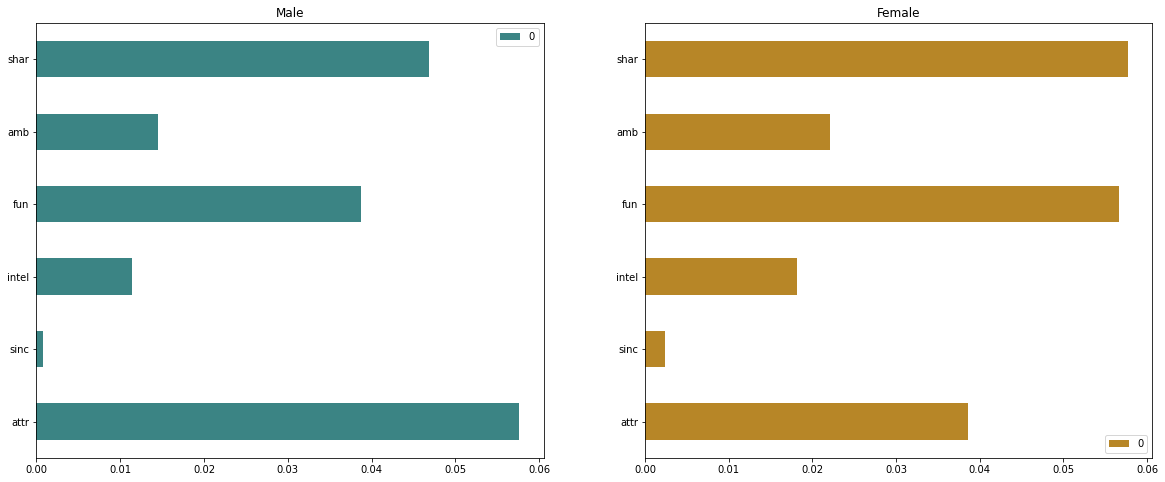

In [259]:
f, ax = verticleCanvas((20, 8))
pd.DataFrame(after_male_coef).plot(kind="barh", ax = ax[0], color = "#3B8484")
ax[0].set_title("Male")
pd.DataFrame(after_female_coef).plot(kind="barh", ax = ax[1], color = "#B78627")
ax[1].set_title("Female")
plt.show()

# Comparing before and after the date

In [260]:
plotRadar(before_male_coef, after_male_coef, [0, 0.08] ,"Importance of attribute variables: before and after. Partner's that male want ")

In [261]:
plotRadar(before_female_coef, after_female_coef, [0, 0.15] ,"Importance of attribute variables: before and after. Partner's that female want ")

## 3.4 Which similarity will increase you chance of getting a date

In [266]:
import statsmodels.api as ols
#OLS MODEL
attr = ols.OLS(similar_male["match"], similar_male.iloc[:,0:4])
result = attr.fit()
result.summary()                                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.331e+08
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                        0.00
Time:                        11:40:33   Log-Likelihood:                          18917.
No. Observations:                4174   AIC:                                 -3.783e+04
Df Residuals:                    4172   BIC:                                 -3.782e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
SameField          0.1846   7.44e+08   2.48e-10      1.000   -1.46e+09    1.46e+09
SameRegion         0.4141   1.82e+09   2.27e-10      1.000   -3.57e+09    3.57e+09
SameRace           0.4156   1.82e+09   2.28e-10      1.000   -3.57e+09    3.57e+09
SharedInterest    -0.0113    2.9e+09  -3.89e-12      1.000   -5.68e+09    5.68e+09
==============================================================================
Omnibus:                      755.593   Durbin-Watson:                   0.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1056.752
Skew:                           1.200   Prob(JB):                    3.38e-230
Kurtosis:                       2.441   Cond. No.                     2.55e+28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.94e-53. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [267]:
similar_male_coef = result.params.abs()

In [268]:
import statsmodels.api as ols
#OLS MODEL
attr = ols.OLS(similar_female["match"], similar_female.iloc[:,0:4])
result = attr.fit()
result.summary()                                    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  match   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.088e+06
Date:                Sun, 24 Apr 2022   Prob (F-statistic):                        0.00
Time:                        11:40:37   Log-Likelihood:                          8971.4
No. Observations:                4125   AIC:                                 -1.794e+04
Df Residuals:                    4123   BIC:                                 -1.793e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
SameField          0.1107   7.39e+09    1.5e-11      1.000   -1.45e+10    1.45e+10
SameRegion         0.5882   1.82e+10   3.22e-11      1.000   -3.58e+10    3.58e+10
SameRace           0.5886   1.82e+10   3.23e-11      1.000   -3.58e+10    3.58e+10
SharedInterest    -0.3189   2.91e+10   -1.1e-11      1.000   -5.71e+10    5.71e+10
==============================================================================
Omnibus:                      730.789   Durbin-Watson:                   0.406
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1118.751
Skew:                          -1.259   Prob(JB):                    1.17e-243
Kurtosis:                       2.584   Cond. No.                     2.28e+28
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.43e-53. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [269]:
similar_female_coef = result.params.abs()

In [270]:
display_side_by_side(pd.DataFrame(similar_male_coef),pd.DataFrame(similar_female_coef), titles=['Male','Female'])

,0
SameField,0.184615
SameRegion,0.414075
SameRace,0.415562
SharedInterest,0.011261
,0
SameField,0.110749
SameRegion,0.588151
SameRace,0.588630
SharedInterest,0.318936


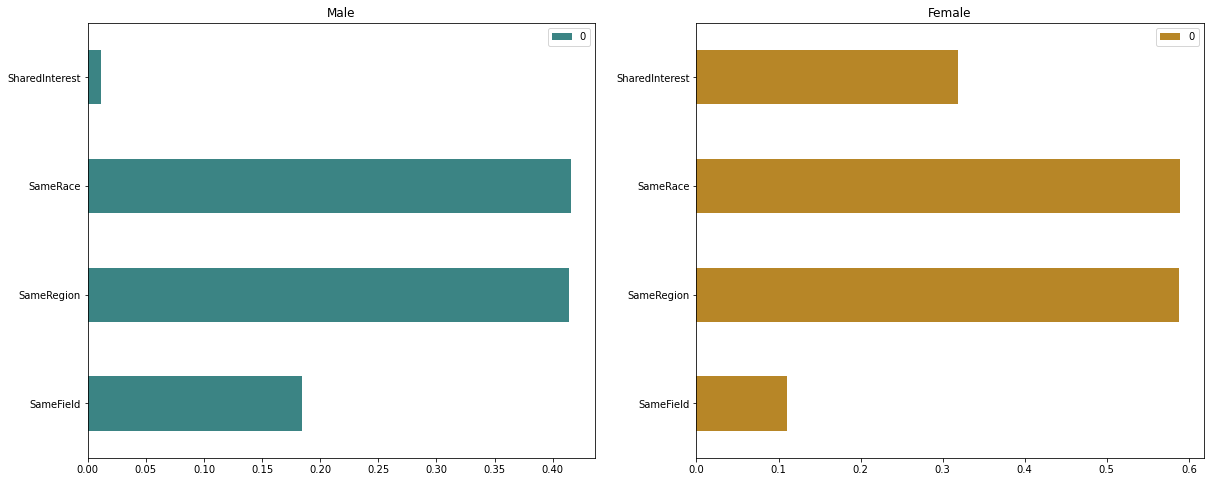

In [271]:
f, ax = verticleCanvas((20, 8))
pd.DataFrame(similar_male_coef ).plot(kind="barh", ax = ax[0], color = "#3B8484")
ax[0].set_title("Male")
pd.DataFrame(similar_female_coef ).plot(kind="barh", ax = ax[1], color = "#B78627")
ax[1].set_title("Female")
plt.show()

# Comparing accuracy with XGBoost, Logistic Rgression, RandomForest

In [ ]:
categories = {
    "similarities": [], 
    "attrBefore":['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'match'], 
    "attrAfter":['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'match'], 
    "satIncome": ['log_mn_sat','log_income','match']
}


In [287]:
X_train, X_test, y_train, y_test = split(after_male, "match")

### Random Forest Model

In [295]:
# RandomForest classifier
model = RandomForestClassifier()
rf_model = model.fit(X_train, y_train)
predict_train_rf = rf_model.predict(X_train)
predict_test_rf = rf_model.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_rf))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_rf))

Training Accuracy: 0.9552344025378922
Validation Accuracy: 0.7887323943661971


### XGBoost Model

In [293]:
# xgboost model
model = GradientBoostingClassifier()
xgb_model = model.fit(X_train, y_train)
predict_train_xgb = xgb_model.predict(X_train)
predict_test_xgb = xgb_model.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_xgb))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_xgb))

Training Accuracy: 0.8466690165667959
Validation Accuracy: 0.8126760563380282


### Logistic Regression Model

In [297]:
# logistic regression classification model
model = LogisticRegression(C=1, random_state=0)
lrc = model.fit(X_train, y_train)
predict_train_lrc = lrc.predict(X_train)
predict_test_lrc = lrc.predict(X_test)
print('Training Accuracy:', metrics.accuracy_score(y_train, predict_train_lrc))
print('Validation Accuracy:', metrics.accuracy_score(y_test, predict_test_lrc))


Training Accuracy: 0.8234050052872753
Validation Accuracy: 0.8112676056338028
